In [3]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../k6/results/ssrh/10000/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    if 'B' in value:
        return str(int(float(value.replace('B', '')) / 1024))
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, dataset, features, height=3, width=20):
    cols = len(features)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, f in enumerate(features):
        plot_func(dataset, f, axes[x], idx=x)
    return plt

In [10]:
dirty_df = pd.read_csv(f'{path}metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']


print(f'NaN rows: \n{dirty_df[[*duration, *throughput]].isna().sum()}')

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)


masks = {}

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

NaN rows: 
duration_mean       0
duration_min        0
duration_max        0
duration_count      0
throughput_mean     1
throughput_min      1
throughput_max      1
throughput_count    0
dtype: int64


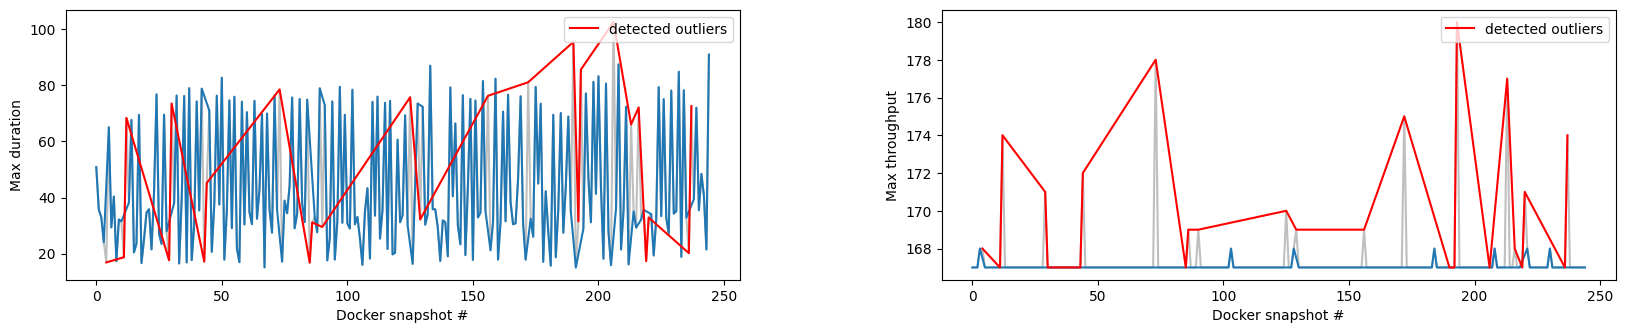

In [6]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

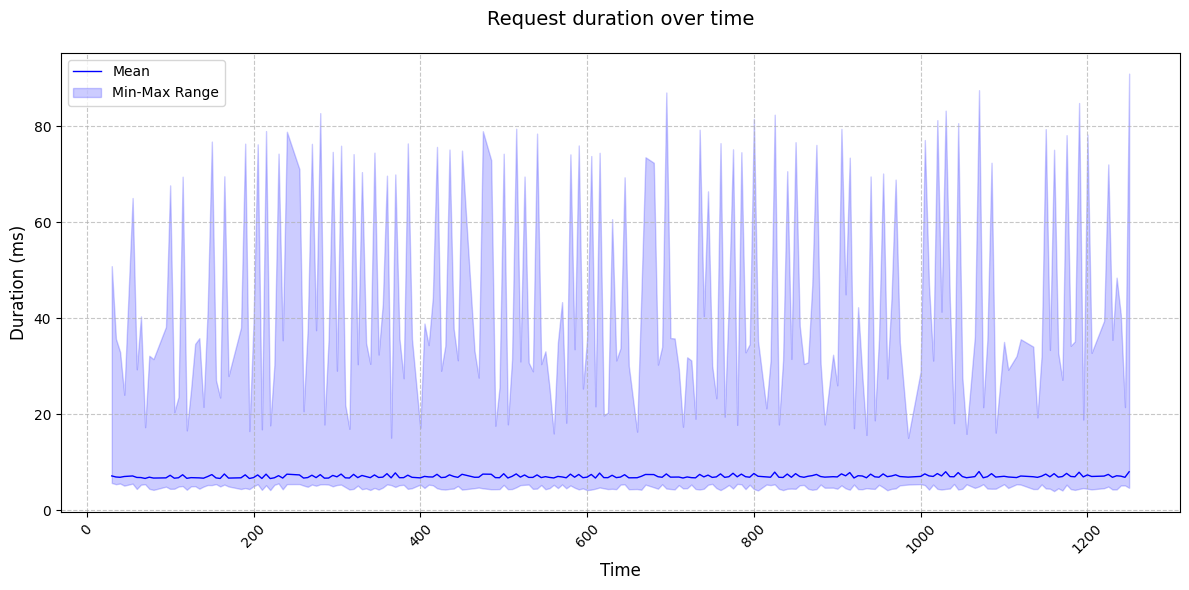

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

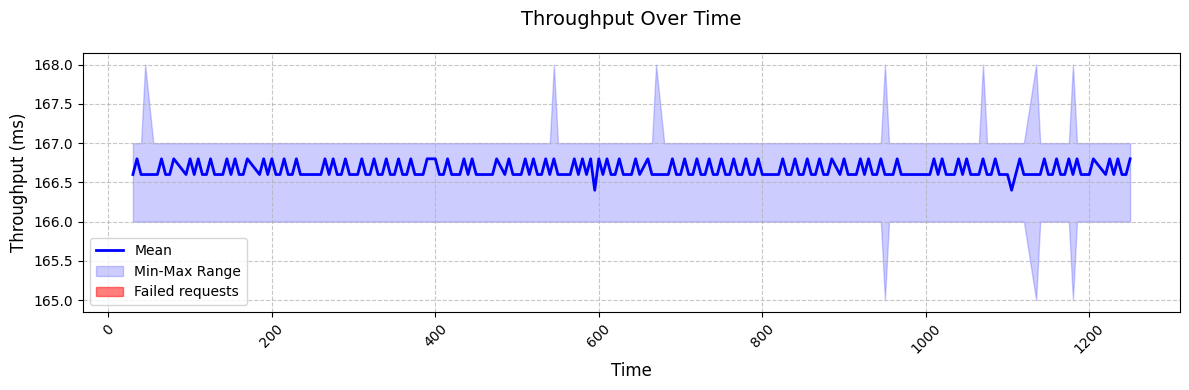

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

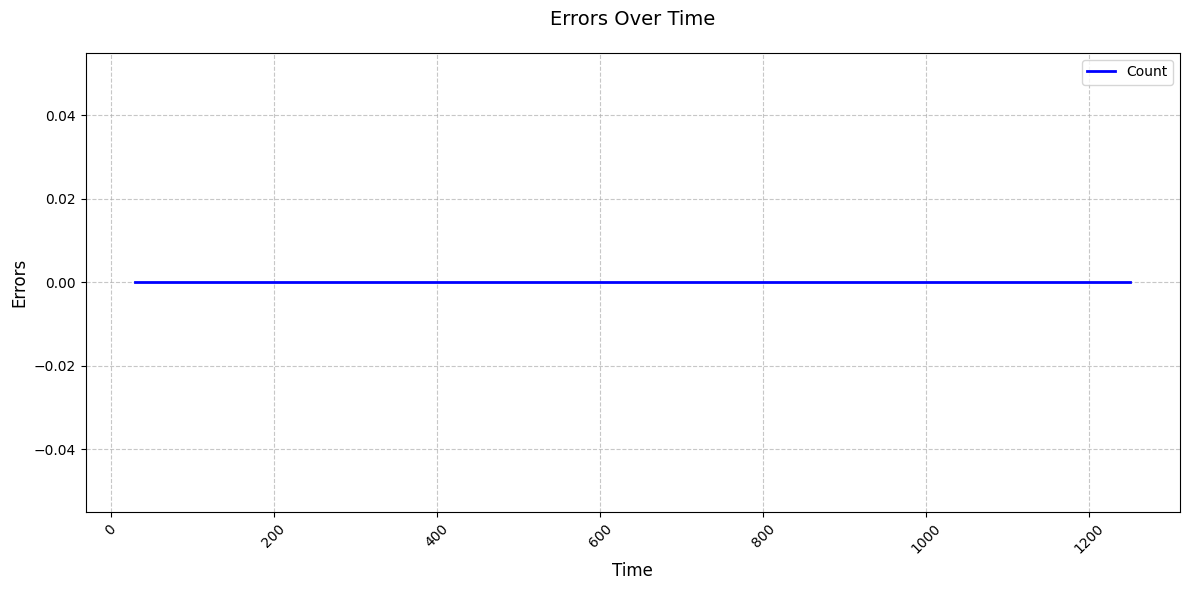

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()